##Propagation through beamline with several optic elements

This example uses wave optics software based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG> 

#TODO
more short explaination about example


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


####Import modules and necessary core and helper functions

In [2]:
import os
import sys
sys.path.insert(0,'/home/meyerann/WPG')

import time
import copy
import numpy
import pylab

#Base wavefront class
from wpg import Wavefront

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

from wpg.srwlib import srwl, SRWLOptD, SRWLOptL, SRWLOptC, SRWLOptA, SRWLOptMirEl, SRWLOptT
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy
#helper functions
#from wfrutilsAKM import plot_wfront
from wpg.useful_code.wfrutils import plot_wfront, get_mesh, print_beamline, calculate_fwhm_x, calculate_fwhm_y, plot_1d, plot_2d

pylab.ion()

In [3]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [4]:
def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr
    
    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile    
    """
    heightProfData = numpy.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    pylab.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')

In [5]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator
    
    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=cos(theta0), _nvy=0, _nvz=-sin(theta0), _tvx=-sin(theta0), _tvy=0, _x=0, _y=0, _treat_in_out=1) 
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=0, _nvy=cos(theta0), _nvz=-sin(theta0), _tvx=0, _tvy=-sin(theta0), _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

#### Defining Gaussian wavefront parameters

Before building initial gaussian wavefront the beam parameters, which defines the behavior and geometry of a Gaussian beam, must be calculated. 

wave length of beam: $\lambda=\frac{12.4}{E[kev]}$ 

angular divergence: $\theta_{FWHM}$ is calculated by using the empirical formula from XFEL CDR2011

beam waist: $\omega_0 = \frac{\lambda}{\pi\theta}$

Rayleigh range: ${z}_R=\frac{\pi{\omega_0}^2}{\lambda}$  At this point the beam is widened to $\sqrt{2}\omega_0$

FWHM at ${z}_R$: $FWHM_{z_R} = \theta_{FWHM}{z}_R$ --> weil sin(theta[theta im bogenmass])=x\laenge=theta

FWHM of amplitude: $\frac{1}{2} = exp(-\frac{x^2}{w^2})$ --> $x = w\sqrt{-ln\frac{1}{2}}$ --> $x = 2\sigma\sqrt{ln2}$

$\sigma$ of amplitude: $ \sigma_{amp} = \frac{FWHM}{2\sqrt{ln2}} $

Expected FWHM at first screen or focusing mirror: $FWHM_{d} = \theta_{FWHM}d$

Afterwards the parameters will be printed out, so the expected FWHM can be compared with the propagated.

In [6]:
#wavefront parameters
qnC = 0.1  # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s]      
ekev = 0.8  # Energy in [keV]
d2HEFM = 284.0 #distance to M2

lamda = 12.4*1e-10/ekev # wavelength [AKM]
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)#angular divergence
w0 = lamda/(pi*theta_fwhm) # beam waist
z_R = (pi*w0**2)/lamda #Rayleigh range
fwhmAtZ_R = theta_fwhm*z_R #FWHM at Rayleigh range
sigmaAmp = w0/(2*sqrt(log(2))) #sigma of amplitude


#Print out the calculated wavefront parameters and expected FWHM
print 'theta_fwhm: %.2f urad' % (theta_fwhm*1e6)
print 'w0 %.3f um:' %(w0*1e6)
print 'lamda %.3f nm:' %(lamda*1e9)
print '2*z_R: %.3f m:' %(2*z_R)
print 'sigma_Amplitude %.3f um:' %(sigmaAmp*1e6)
#print 'expected FWHM at distance Rayleigh length %.1f nm: %.2f um' %(z_R,fwhmAtZ_R*1e6)
print 'expected FWHM at distance %.1f: %.2f mm' %(d2HEFM,theta_fwhm*d2HEFM*1e3)

theta_fwhm: 18.35 urad
w0 26.893 um:
lamda 1.550 nm:
2*z_R: 2.932 m:
sigma_Amplitude 16.151 um:
expected FWHM at distance 284.0: 5.21 mm


####Building initial Gaussian wavefront
With the calculated beam parameters the initial wavefront is build with 400x400 data points and in distance of the first horizontal elliptical focusing mirror (M2) at 284m. For further propagation the built wavefront should be stored. After plotting the wavefront the FWHM should be printed out for comparing.

######beam radius at several point and range gaussian beam
$\omega(z) = \omega_0*\sqrt{1+(\frac{z\lambda}{\pi\omega_0^2})^2}$ 

$\frac{1}{z_R} = \frac{\lambda}{\pi\omega_0^2}$

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_R})^2}$

#####beam size is a little bit (ca 200nm )smaller than expected. Is it because the calculating of the expected FWHM is approximatly???

beam radius at several point
$\omega(z) = \omega_0*\sqrt{1+(\frac{z\lambda}{\pi\omega_0^2})^2}$ 

$\frac{1}{z_R} = \frac{\lambda}{\pi\omega_0^2}$

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_R})^2}$



range_xy : 0.0260512778504
saving WF to data_common/gwf.h5
FWHMx [mm]: 5.02743958516
FWHMy [mm]: 5.02743958516
Coordinates of center, [mm]: 0.032645711592 0.032645711592
stepX, stepY [um]: 65.2914231839 65.2914231839 

 
 FWHM at distance 284.0: 5.027 mm


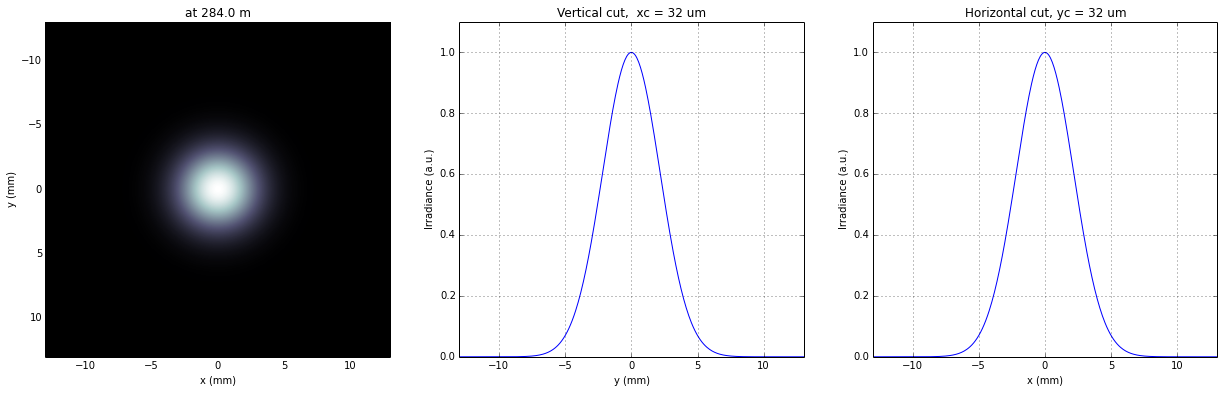

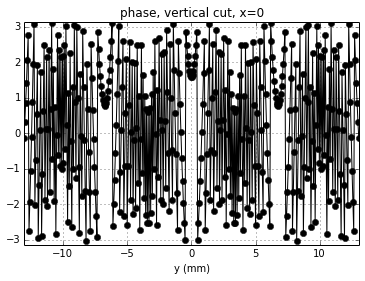

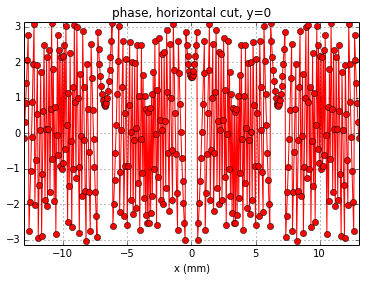

In [7]:
#number of points
np = 400

#quintuple beam radius at horizontal lens distance to get the range of the wavefront 
range_xy = w0*sqrt(1+(d2HEFM/z_R)**2) *5
print 'range_xy :', range_xy

#build wavefront
wfr = build_gauss_wavefront_xy(nx=np, ny=np, ekev=ekev, xMin=-range_xy/2, xMax=range_xy/2, 
                               yMin=-range_xy/2, yMax=range_xy/2, sigX=sigmaAmp, 
                               sigY=sigmaAmp,d2waist=d2HEFM)
#init WPG Wavefront with helper class
mwf = Wavefront(wfr)

#defining name HDF5 file for storing wavefront
strOutInDataFolder = 'data_common'
wfr0Name = os.path.join(strOutInDataFolder,'gwf'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(wfr0Name)
print 'saving WF to %s' %wfr0Name

#plot the wavefront
plot_wfront(mwf, title_fig='at '+str(d2HEFM)+' m', isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
print ' '
print ' FWHM at distance %.1f: %.3f mm' %(d2HEFM,calculate_fwhm_x(mwf)*1e3)

### Focusing with horizontal elliptical focusing offset mirror (M2)

The wavefront will be focused with a focusing offset mirror (M2) at distance (284.0m) in horizon plane. Before focusing the beam the expected beam size after the propagation at point of focus and calculating distances of focus.

Focal length for thin lenses will be calculated by

$\frac{1}{f}=\frac{1}{p}+\frac{1}{q}$

The expected FWHM at focus will be calculated with proportion of the distances after and before the lens multiplied by the FWHM at source 

$FWHM_{focus}=\frac{q}{p}*FWHM_{source}$

In [8]:
horizontalFocus = 374.0 #given point of where the focus should be
q = horizontalFocus-d2HEFM # distance between horizontal focusing lens and given point of focus
d2horizontalFocus =1./(1./d2HEFM + 1./q) #calculating horizontal focal length

thetaEM = 52.4e-3   # incidence angle of elliptical  mirror, 3 deg
lengthM = 0.5 #[m]
FWHM_1HFocus = q/d2HEFM*fwhmAtZ_R #calculating expected FWHM of beam at focus
print 'd2verticalFocus = %.1f m' %(q)
print 'horizontalFocus at distance %.1f m' %(d2horizontalFocus+d2HEFM)
print 'expected horizontal FWHM at distance %.1f: %.2f um' %(horizontalFocus,FWHM_1HFocus*1e6)


d2verticalFocus = 90.0 m
horizontalFocus at distance 352.3 m
expected horizontal FWHM at distance 374.0: 8.52 um


### 1.a) Building beamline with optical elements
The beamline consists of an aperture infront of the horizontal lens, to clean up the beam, the lens and the drift after lens to the focus. So the wavefront is propagated from first horizontal lans at 284m to given focus at 374m.




loading WF from data_common/gwf.h5
p = 284.0 m
q 90.0 m
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 5.0, 1.0, 2.0, 0, 0, 0]
	Dx = 0.0048
	Dy = 0.0260512778504
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Mirror: Ellipsoid
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0
	Fy = 0
	angGraz = 0.0524
	apShape = r
	arRefl = array of size 2
	ds = 1
	dt = 0.5
	extIn = 0
	extOut = 0
	meth = 2
	nps = 500
	npt = 500
	nvx = 0.998627434104
	nvy = 0
	nvz = -0.0523760236546
	p = 284.0
	q = 90.0
	radSag = 1e+40
	reflAngFin = 0
	reflAngScaleType = lin
	reflAngStart = 0
	reflNumAng = 1
	reflNumComp = 1
	reflNumPhEn = 1
	reflPhEnFin = 1000.0
	reflPhEnScaleType = lin
	reflPhEnStart = 1000.0
	treatInOut = 1
	tvx = -0.0523760236546
	tvy = 0
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 90.0
	treat = 0
	

saving WF to data_common/gwf_AKM_BL0.h5
FWHMx [mm]: 0.019678670

ValueError: zero-size array to reduction operation minimum which has no identity

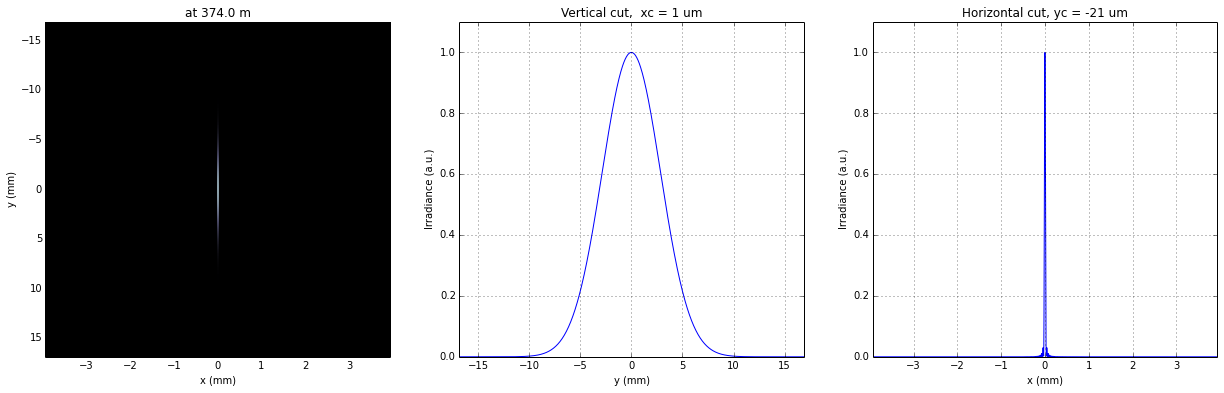

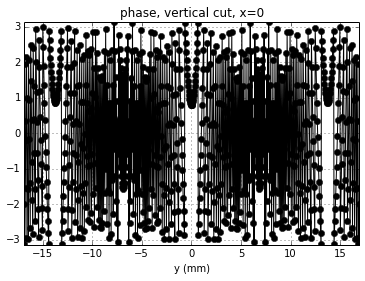

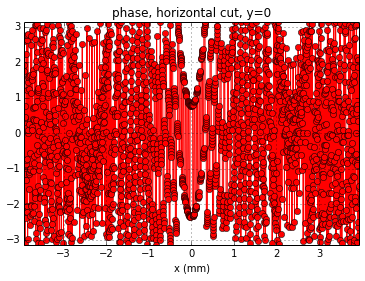

MemoryError: 

In [9]:
w2 = Wavefront()
w2.load_hdf5(wfr0Name)
print 'loading WF from %s' %wfr0Name

wfr = w2._srwl_wf

print 'p = %.1f m' %(d2HEFM)
print 'q %.1f m' %(q)

#horizontal apterure size
#thetaOM = 3.5e-3 
thetaOM = 6e-3 
horApM1 = 0.8*thetaOM

opAp0 = SRWLOptA('r', 'a',horApM1,range_xy) 

DriftHEFM_Focus = SRWLOptD(q)
HorizontalEFM = defineEFM(orient='x',p=d2HEFM ,q=q,thetaEFM=thetaEM,theta0=thetaEM,
                          lengthEFM=lengthM)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification) (Zoom)
#[6]:  Horizontal Resolution modification factor at Resizing (step size)
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppAp0 =          [ 0,  0, 1.0,  0,  0, 1.0, 1./0.2, 1.0, 1.0/0.5,  0,  0,   0]
ppApX =          [ 0,  0, 1.0,  0,  0, 0.1, 1., 1.0, 1.0,  0,  0,   0]
ppAp1 =          [ 0,  0, 1.0,  0,  0, 1.2/0.5, 1./0.05, 1.0, 1.0/0.5,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppHorizontalEFM = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftHEFM_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

#optBL0 = SRWLOptC([opAp0, HorizontalEFM, opTrErM1, DriftHEFM_Focus],
#                  [ppAp0, ppHorizontalEFM, ppTrErM1, ppDriftHEFM_foc])
optBL0 = SRWLOptC([opAp0, HorizontalEFM, DriftHEFM_Focus],
                  [ppAp0, ppHorizontalEFM, ppDriftHEFM_foc])

#drift navch obstacle 5m
DriftFocus2Screen = SRWLOptD(5)

opOpstacle1 = SRWLOptA('r', 'o',range_xy/2,range_xy) 
optBL5 = SRWLOptC([opOpstacle1],
                  [ppAp1])
#optBL5 = SRWLOptC([opOpstacle1, DriftFocus2Screen],
#                  [ppAp1, ppDriftHEFM_foc])

print_beamline(optBL0)

srwl.PropagElecField(wfr, optBL0)
mwf = Wavefront(wfr)
wfr1Name = os.path.join(strOutInDataFolder,'gwf_AKM_BL0'+'.h5')
mwf.store_hdf5(wfr1Name)
print 'saving WF to %s' %wfr1Name



plot_wfront(mwf, title_fig='at '+str(horizontalFocus)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(horizontalFocus,calculate_fwhm_x(mwf)*1e6)
print ' total length:', mwf.params.Mesh.zCoord

print_beamline(optBL5)
srwl.PropagElecField(wfr, optBL5)
mwf = Wavefront(wfr)

print 'Plot mit obstacle'
plot_wfront(mwf, title_fig='at '+str(horizontalFocus+5)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '

### 1.b) Building beamline with optical elements
The beamline consists of an obstacle infront of the horizontal lens, to clean up the beam, the lens and the drift after lens to the focus. So the wavefront is propagated from first horizontal lans at 284m to given focus at 374m.

loading WF from data_common/gwf.h5
p = 284.0 m
q 90.0 m
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 5.0, 1.0, 2.0, 0, 0, 0]
	Dx = 0.0048
	Dy = 0.0260512778504
	ap_or_ob = o
	shape = r
	x = 0
	y = 0
	
Optical Element: Mirror: Ellipsoid
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0
	Fy = 0
	angGraz = 0.0524
	apShape = r
	arRefl = array of size 2
	ds = 1
	dt = 0.5
	extIn = 0
	extOut = 0
	meth = 2
	nps = 500
	npt = 500
	nvx = 0.998627434104
	nvy = 0
	nvz = -0.0523760236546
	p = 284.0
	q = 90.0
	radSag = 1e+40
	reflAngFin = 0
	reflAngScaleType = lin
	reflAngStart = 0
	reflNumAng = 1
	reflNumComp = 1
	reflNumPhEn = 1
	reflPhEnFin = 1000.0
	reflPhEnScaleType = lin
	reflPhEnStart = 1000.0
	treatInOut = 1
	tvx = -0.0523760236546
	tvy = 0
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 90.0
	treat = 0
	

saving WF to data_common/gwf_AKM_BL0.h5
FWHMx [mm]: 0.025839184

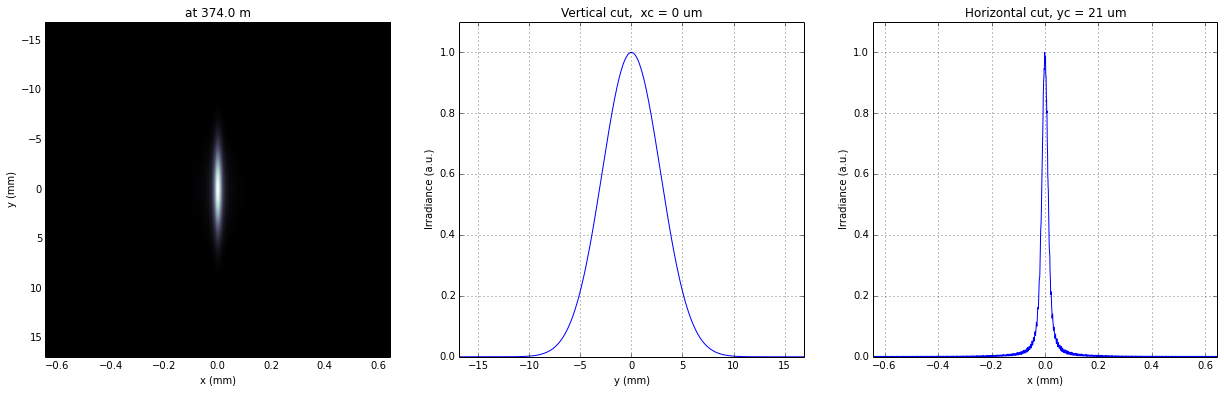

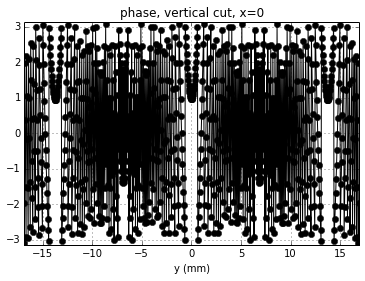

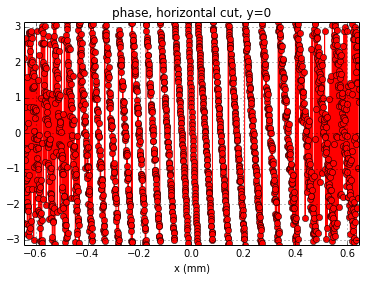

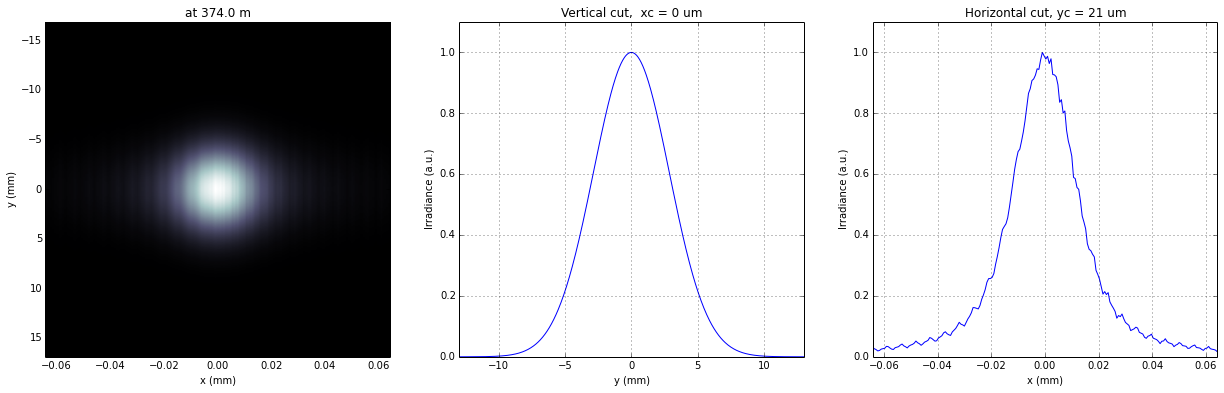

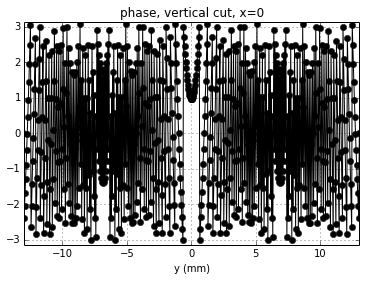

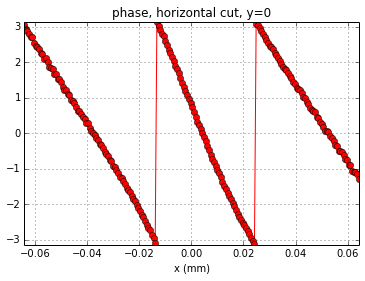

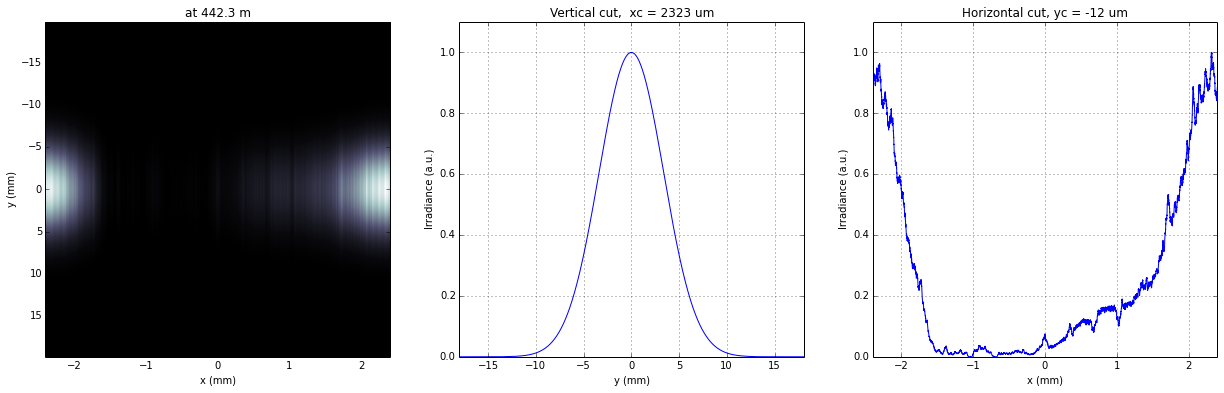

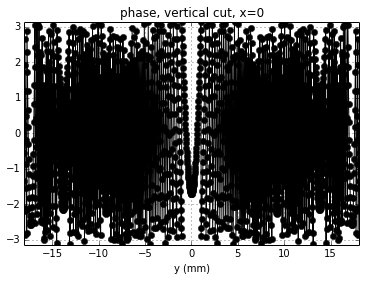

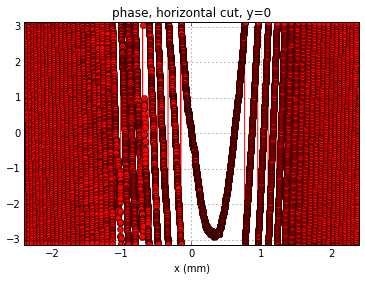

In [10]:
w2 = Wavefront()
w2.load_hdf5(wfr0Name)
print 'loading WF from %s' %wfr0Name

wfr = w2._srwl_wf

print 'p = %.1f m' %(d2HEFM)
print 'q %.1f m' %(q)

#horizontal apterure size
#thetaOM = 3.5e-3 
thetaOM = 6e-3 
horApM1 = 0.8*thetaOM

opAp0 = SRWLOptA('r', 'o',horApM1,range_xy) 

DriftHEFM_Focus = SRWLOptD(q)
HorizontalEFM = defineEFM(orient='x',p=d2HEFM ,q=q,thetaEFM=thetaEM,theta0=thetaEM,
                          lengthEFM=lengthM)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification) (Zoom)
#[6]:  Horizontal Resolution modification factor at Resizing (step size)
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppAp0 =          [ 0,  0, 1.0,  0,  0, 1.0, 1./0.2, 1.0, 1.0/0.5,  0,  0,   0]
ppApX =          [ 0,  0, 1.0,  0,  0, 0.1, 1., 1.0, 1.0,  0,  0,   0]
ppAp1 =          [ 0,  0, 1.0,  0,  0, 1.2/0.5, 1./0.05, 1.0, 1.0/0.5,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppHorizontalEFM = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftHEFM_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

#optBL0 = SRWLOptC([opAp0, HorizontalEFM, opTrErM1, DriftHEFM_Focus],
#                  [ppAp0, ppHorizontalEFM, ppTrErM1, ppDriftHEFM_foc])
optBL0 = SRWLOptC([opAp0, HorizontalEFM, DriftHEFM_Focus],
                  [ppAp0, ppHorizontalEFM, ppDriftHEFM_foc])
opApX = SRWLOptA('r', 'a',120e-3,range_xy) 
optBL4 = SRWLOptC([opApX],
                  [ppApX])

dScreen = 442.3
DriftFocus2Screen = SRWLOptD(dScreen-horizontalFocus)
opAp1 = SRWLOptA('r', 'a',120e-3,range_xy) 
optBL5 = SRWLOptC([opAp1, DriftFocus2Screen],
                  [ppAp1, ppDriftHEFM_foc])

print_beamline(optBL0)

srwl.PropagElecField(wfr, optBL0)
mwf = Wavefront(wfr)
wfr1Name = os.path.join(strOutInDataFolder,'gwf_AKM_BL0'+'.h5')
mwf.store_hdf5(wfr1Name)
print 'saving WF to %s' %wfr1Name



plot_wfront(mwf, title_fig='at '+str(horizontalFocus)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(horizontalFocus,calculate_fwhm_x(mwf)*1e6)
print ' total length:', mwf.params.Mesh.zCoord

srwl.PropagElecField(wfr, optBL4)
mwf = Wavefront(wfr)
plot_wfront(mwf, title_fig='at '+str(horizontalFocus)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '

srwl.PropagElecField(wfr, optBL5)
mwf = Wavefront(wfr)
plot_wfront(mwf, title_fig='at '+str(dScreen)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '

### 1.b) Building the same beamline with added error profile on the first horizontal focusing mirror

In [ ]:
w2 = Wavefront()
w2.load_hdf5(wfr0Name)
print 'loading WF from %s' %wfr0Name

wfr = w2._srwl_wf

scale = 2

#opTrErM1 = SRWLOptT(1500, 100, horApM1 , range_xy)
opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)

#defineOPD(opTrErM1, os.path.join(strOutInDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
defineOPD(opTrErM1, os.path.join(strOutInDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
opdTmp=numpy.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)


#to plot profile of mirror
figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')  

optBL1 = SRWLOptC([opAp0, HorizontalEFM, opTrErM1, DriftHEFM_Focus],
                  [ppAp0, ppHorizontalEFM, ppTrErM1, ppDriftHEFM_foc])
#optBL1 = SRWLOptC([opAp0, HorizontalEFM, opTrErM1],
#                  [ppAp0, ppHorizontalEFM, ppTrErM1])

#optBL1 = SRWLOptC([opAp0, HorizontalEFM],
#                  [ppAp0, ppHorizontalEFM])
print_beamline(optBL1)

srwl.PropagElecField(wfr, optBL1)
mwf = Wavefront(wfr)
wfr2Name = os.path.join(strOutInDataFolder,'gwf_AKM_BL1'+'.h5')
mwf.store_hdf5(wfr1Name)
print 'saving WF to %s' %wfr2Name

plot_wfront(mwf, title_fig='at '+str(horizontalFocus)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(horizontalFocus,calculate_fwhm_x(mwf)*1e6)
print ' total length:', mwf.params.Mesh.zCoord

In [ ]:
d2HKB = 442.3
dHKB_foc = 2.715  # nominal focal length for HFM KB
p2 = d2HKB-horizontalFocus

HKB_foc =  1. /(1./p2 + 1. / dHKB_foc) # for thin lens approx

FWHM_2HFocus = dHKB_foc/p2*fwhmAtZ0
print 'vertical KB focus: %.3f m' %(HKB_foc)
print 'p2 [m]:', p2
print 'q/p :', dHKB_foc/p2
print 'expected horizontal FWHM at distance %.1f: %.3f um' %(d2HKB + dHKB_foc,FWHM_2HFocus*1e6)


In [ ]:
#loading wavefront
w2 = Wavefront()
w2.load_hdf5(wfr2Name)
print 'loading WF to %s' %wfr2Name
wfr = w2._srwl_wf

#defining first aperture
Ap1Focus = horizontalFocus
FWHM_1HFocus = q/d2HEFM*fwhmAtZ0
print 'p = d2HEFM [m]', d2HEFM
print 'q [m]', q
print 'FWHM_1HFocus [um]', FWHM_1HFocus
#opAp1Focus = SRWLOptA('r', 'a',3*FWHM_1HFocus*1e-6,20.e-3)
print 'horApM1:', horApM1
#apSizeX = 250.e-6
apSizeX = 3*calculate_fwhm_x(mwf)
#apSizeY = 250.e-3
apSizeY = 3*calculate_fwhm_y(mwf)
opAp1Focus = SRWLOptA('r', 'a',apSizeX,apSizeY)
#opAp1Focus = SRWLOptA('r', 'a',2*theta_fwhm*p2,20.e-3) 
print 'Aperturesize horizontal: %.6f mm' %(apSizeX)
print 'Aperturesize vertical: %.6f mm' %(apSizeY)

lengthKB = 0.8
#thetaKB = 3.5e-3
thetaKB = 9.e-3
apSizeKB = thetaKB*lengthKB

opApKB = SRWLOptA('r', 'a',apSizeKB,apSizeKB)

HKB = SRWLOptL(_Fx=HKB_foc) #HKB as Thin Lens
DriftHFocus1_HKB = SRWLOptD(p2) #
DriftHEFM_Focus2 = SRWLOptD(dHKB_foc)

#ppAp0 =          [ 0,  1, 1.0,  0,  0, 1.0, 1./0.2, 1.0, 1.0/0.5,  0,  0,   0]
#ppApKB =       [ 0,  0, 1.0,  0,  0, 0.25, 1./0.5, 1.0, 1.0,  0,  0,   0]
ppAp1Foc =        [ 0,  0, 1.0,  0,  0, 2., 1./0.75, 1., 1.0/1.0,  0,  0,   0]
ppDrift2HKB =     [ 0,  0, 1.0,  0,  0, 2., 1.0,  1.0, 1.0,      0,  0,   0]

ppApKB =        [ 0,  0, 1.0,  0,  0, 0.25, 1./0.1, 1.0, 1.0/1.0,  0,  0,   0]
ppHorEFM =      [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftHEFM_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

#optBL2 = SRWLOptC([opAp1Focus],
#                  [ppAp1Foc])
#optBL2 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB],
#                  [ppAp1Foc,   ppDrift2HKB])
#optBL2 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, opApKB],
#                  [ppAp1Foc, ppDrift2HKB, ppApKB)
#optBL2 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, opApKB, HKB],
#                  [ppAp1Foc, ppDrift2HKB, ppApKB, ppHorEFM] )
optBL2 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, opApKB, HKB, DriftHEFM_Focus2],
                  [ppAp1Foc, ppDrift2HKB, ppApKB, ppHorEFM, ppDriftHEFM_foc])



print_beamline(optBL2)


srwl.PropagElecField(wfr, optBL2)
mwf = Wavefront(wfr)
wfr3Name = os.path.join(strOutInDataFolder,'gwf_AKM_BL2'+'.h5')
mwf.store_hdf5(wfr3Name)
print 'saving WF to %s' %wfr3Name

#mwf.store_hdf5(wfr0Name)
plot_wfront(mwf, title_fig='at '+str(d2HKB+dHKB_foc)+' m', isHlog=False, isVlog=False, 
            i_x_min=-1e-6, i_y_min=-1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(d2HKB + dHKB_foc,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord


### Circular Aperture with double size of FWHM in first focus and afterwards focusing with second horizontal EFM as KB
Calculating expected beam size after propagation and
propagate wavefront from frist horizontal focus with aperture at 400 m to focus of KB lens at 444 m.

In [ ]:
w2 = Wavefront()
w2.load_hdf5(wfr3Name)
print 'loading WF to %s' %wfr3Name

wfr = w2._srwl_wf

#defining first aperture
Ap1Focus = horizontalFocus
FWHM_1HFocus = q/d2HEFM*fwhmAtZ0
print 'p = d2HEFM [m]', d2HEFM
print 'q [m]', q
print 'FWHM_1HFocus [um]', FWHM_1HFocus*1e6
#opAp1Focus = SRWLOptA('r', 'a',3*FWHM_1HFocus*1e-6,20.e-3)
opAp1Focus = SRWLOptA('r', 'a',250*1e-6,20.e-3)
#opAp1Focus = SRWLOptA('r', 'a',2*theta_fwhm*p2,20.e-3) 
print 'Aperturesize: %.6f mm' %(30*FWHM_1HFocus*1e-6)


DriftHEFM_Focus2 = SRWLOptD(dHKB_foc)
HorizontalEFM2 = defineEFM(orient='x',p=p2,q=dHKB_foc,thetaEFM=thetaEM,theta0=thetaEM,
                           lengthEFM=lengthM)
#HorizontalEFM = defineEFM(orient='x',p=d2HEFM ,q=q,thetaEFM=thetaEM,theta0=thetaEM,
#                          lengthEFM=lengthM)

HKB = SRWLOptL(_Fx=HKB_foc) #VKB as Thin Lens
#               [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
#ppAp0 =        [ 0,  1, 1.0,  0,  0, 2.0, 1./0.1, 4.0, 1.0/0.4,  0,  0,   0]
ppApKB =       [ 0,  0, 1.0,  0,  0, 0.25, 1./0.5, 1.0, 1.0,  0,  0,   0]
#ppApKB =        [ 0,  1, 1.0,  0,  0, 2.0, 1./0.1, 4.0, 1.0/0.4,  0,  0,   0]
ppDrift2HKB =   [ 0,  0, 1.0,  1,  0, 1, 1.0, 2.0, 1.0,  0,  0,   0]
ppHorEFM =      [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
#ppDriftHEFM_foc = [ 0,  1, 1.0,  1,  0, 2.0, 0.5, 2.0, 1.0,  0,  0,   0]
ppDriftHEFM_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]


DriftHFocus1_HKB = SRWLOptD(p2)
Drift2Focus = SRWLOptD(dHKB_foc)
#optBL3 = SRWLOptC([opAp1Focus],
#                  [ppApKB]) 
#optBL3 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB],
#                  [ppApKB, ppDrift2HKB]) 
#optBL3 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, HorizontalEFM2, DriftHEFM_Focus2],
#                  [ppApKB, ppDrift2HKB,ppHorEFM, ppDriftHEFM_foc]) 
#optBL3 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, HorizontalEFM2],
#                  [ppApKB, ppDrift2HKB, ppHorEFM])
optBL3 = SRWLOptC([opAp1Focus, DriftHFocus1_HKB, HKB, DriftHEFM_Focus2],
                  [ppApKB, ppDrift2HKB, ppHorEFM, ppDriftHEFM_foc])
#optBL3 = SRWLOptC([DriftHFocus1_HKB, opAp1Focus],
#                  [ppDrift2HKB, ppApKB])
#optBL3 = SRWLOptC([DriftHFocus1_HKB],
#                  [ppDrift2HKB])

print_beamline(optBL3)


srwl.PropagElecField(wfr, optBL3)
mwf = Wavefront(wfr)
wfr2Name = os.path.join(strOutInDataFolder,'gwf_AKM_BL3'+'.h5')
mwf.store_hdf5(wfr2Name)
print 'saving WF to %s' %wfr2Name

#mwf.store_hdf5(wfr0Name)
plot_wfront(mwf, title_fig='at '+str(d2HKB+dHKB_foc)+' m', isHlog=False, isVlog=False, 
            i_x_min=-1e-4, i_y_min=-1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(d2HKB + dHKB_foc,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

In [ ]:
plot_wfront(mwf, title_fig='at '+str(d2HKB+dHKB_foc)+' m', isHlog=True, isVlog=False, 
            i_x_min=-1e-1, i_y_min=-1e-4, orient='x', onePlot=True, bPlotPha=True)


### Plot wavefront out of focus at rayleigh length with circular aperture in Focus
Propagate the beamline further to distance of rayleigh length at 446m

In [ ]:
DriftOutOfFocus= SRWLOptD(z0*1e-9)
print 'z0 [nm] :', z0
#defining second aperture in KB focus
Ap2Focus = dHKB_foc + d2HKB
opAp2Focus = SRWLOptA('c', 'a', 2*theta_fwhm*horizontalFocus) 
print 'Aperturesize: %.2f mm' %(2*theta_fwhm*horizontalFocus*1e3)

ppApKB =        [ 0,  0, 1.0,  0,  0, 1, 4.0, 1, 4.0,  0,  0,   0]
ppDriftOutOfFocus = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
optBL2 = SRWLOptC([opAp2Focus, DriftOutOfFocus],
                  [ppApKB, ppDriftOutOfFocus]) 
print_beamline(optBL2)

w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf

srwl.PropagElecField(wfr, optBL2)
mwf = Wavefront(wfr)

plot_wfront(mwf, title_fig='at '+str(d2HKB + dHKB_foc +z0*1e-9)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='y', onePlot=True, bPlotPha=True)
print ' '
print 'horicontal FWHM at distance %.1f: %.3f mm' %(d2HKB + dHKB_foc +z0*1e-9,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

In [ ]:
2*sqrt(2*log(2))